C:\Users\USER\AppData\Local\Temp\ipykernel_6720\1605568746.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[df['Date'] < split_date]
C:\Users\USER\AppData\Local\Temp\ipykernel_6720\1605568746.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[df['Date'] >= split_date]


Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.57      0.35      0.43        49
           1       0.54      0.75      0.63        51

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.53       100
weighted avg       0.55      0.55      0.53       100



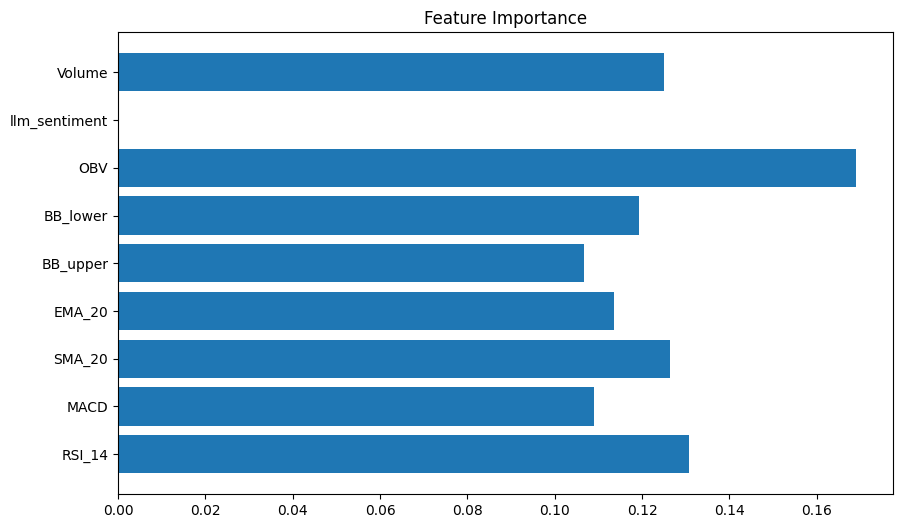

In [ ]:
import pandas as pd
import numpy as np
from binance.client import Client
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

client = Client()
klines = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY, limit=500)
df = pd.DataFrame(klines, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
                                  'Quote volume', 'Trades', 'Taker buy volume', 'Taker quote volume', 'Ignore'])
df['Date'] = pd.to_datetime(df['Open time'], unit='ms')
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

def add_indicators(df):
    # Momentum
    df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df['Close']).macd()

    # Trend
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

    # Volatility
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    # Volume
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    return df

df = add_indicators(df)

sentiment_df = pd.read_csv('llm_sentiment_scores.csv')
sentiment_df['Date'] = pd.to_datetime(sentiment_df['publishedAt']).dt.tz_localize(None)
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)


daily_sentiment = sentiment_df.groupby('Date')['llm_sentiment'].mean().reset_index()
df = pd.merge(df, daily_sentiment, on='Date', how='left')

df['llm_sentiment'] = df['llm_sentiment'].fillna(0)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
features = [
    'RSI_14', 'MACD', 'SMA_20', 'EMA_20', 
    'BB_upper', 'BB_lower', 'OBV', 
    'llm_sentiment', 'Volume'
]
X = df[features].dropna()
y = df.loc[X.index, 'Target']

split_date = df['Date'].quantile(0.8)
X_train = X[df['Date'] < split_date]
y_train = y[df['Date'] < split_date]
X_test = X[df['Date'] >= split_date]
y_test = y[df['Date'] >= split_date]

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()